If code stops due to low GPU VRAM disconnect and reconnect the runtime with T4

and please upload dataset in colab

Installations and imports¶

In [1]:
!pip install accelerate==0.21.0 bitsandbytes==0.40.2 transformers==4.31.0 scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.

In [2]:
!pip install peft==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00


In [3]:
!pip install trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
!pip install --upgrade peft trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.3.0
    Uninstalling peft-0.3.0:
      Successfully uninstalled peft-0.3.0


In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [6]:
import torch
print(f"pytorch version {torch.__version__}")

pytorch version 2.2.1+cu121


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


The code below prepares the data and key evaluation functions:

1. **Data Reading**: It reads a CSV file named "all-data.csv" containing two columns: "sentiment" and "text".

2. **Data Splitting**: It divides the dataset into training and test sets, with 300 samples in each. This split is done in a way that ensures each set has a balanced representation of positive, neutral, and negative sentiments.

3. **Data Shuffling**: The training data is shuffled in a reproducible manner using a specific random state (random_state=10).

4. **Prompt Transformation**: It converts the text in both the training and test sets into prompts for use by the Llama model. The training prompts include the expected answer for fine-tuning the model.

5. **Evaluation Data Creation**: The remaining examples not included in the training or test sets are used for reporting during training but not for early stopping. This evaluation data is sampled with replacement to ensure a balanced distribution of sentiments (50/50/50) since there are very few negative instances.

6. **Data Wrapping**: The training and evaluation datasets are wrapped using the Hugging Face Dataset class (https://huggingface.co/docs/datasets/index).

Overall, this code prepares the `train_data`, `eval_data`, and `test_data` datasets in a single cell for use in fine-tuning a model.

In [9]:
filename = "/content/all-data.csv"

df = pd.read_csv(filename,
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment],
                                    train_size=300,
                                    test_size=300,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

Here's a rephrased version:

We then define a function to assess the performance of our sentiment analysis model after fine-tuning. This function does the following:

1. Converts sentiment labels to numbers: 2 for positive, 1 for neutral, and 0 for negative.
2. Computes the accuracy of the model on the test data.
3. Produces an accuracy report for each sentiment category.
4. Generates a detailed classification report.
5. Creates a confusion matrix to visualize the model's performance.

In [10]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

#Base model

Here's a more straightforward explanation:

1. Load the Llama-2 language model from the Hugging Face Hub.
2. Obtain the float16 data type from the torch library, which will be used for computations.
3. Create a BitsAndBytesConfig object with the following settings:
   - load_in_4bit: Load the model weights in 4-bit format.
   - bnb_4bit_quant_type: Use the "nf4" quantization type, which is optimal for normally distributed weights.
   - bnb_4bit_compute_dtype: Use the float16 data type for computations.
   - bnb_4bit_use_double_quant: Do not use double quantization.
4. Create an AutoModelForCausalLM object from the pre-trained Llama-2 language model, using the BitsAndBytesConfig object for quantization.
5. Disable caching for the model.
6. Set the pre-training token probability to 1.

Tokenizer loading:
1. Load the tokenizer for the Llama-2 language model.
2. Set the padding token to be the end-of-sequence (EOS) token.
3. Set the padding side to be "right", which means that input sequences will be padded on the right side. This is important for correct padding direction with Llama 2.

In [11]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "llama-2-7b-miniguanaco"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [12]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [13]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 1,
                        temperature = 0.0,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

In [14]:
y_pred = predict(test, model, tokenizer)

  0%|          | 0/900 [00:00<?, ?it/s]Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
100%|██████████| 900/900 [03:47<00:00,  3.96it/s]


At this point, we are ready to test the Llama 2 7b-hf model and see how it performs on our problem without any fine-tuning.

In [15]:
evaluate(y_true, y_pred)

Accuracy: 0.716
Accuracy for label 0: 0.977
Accuracy for label 1: 0.323
Accuracy for label 2: 0.847

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       300
           1       0.81      0.32      0.46       300
           2       0.65      0.85      0.74       300

    accuracy                           0.72       900
   macro avg       0.74      0.72      0.68       900
weighted avg       0.74      0.72      0.68       900


Confusion Matrix:
[[293   5   2]
 [ 68  97 135]
 [ 28  18 254]]


#Base line model accuracy 71.56%

Correct predictions = 293 + 97 + 254 = 644
Total predictions = 293 + 5 + 2 + 68 + 97 + 135 + 28 + 18 + 254 = 900

Accuracy = Correct predictions / Total predictions
Accuracy = 644 / 900
Accuracy ≈ 0.7156

Here's a simplified explanation for Fine-tune :

In the next cell, we prepare for fine-tuning by setting up a Simple Fine-tuning Trainer (SFTTrainer) using the Parameter-Efficient Fine-Tuning (PEFT) method. PEFT focuses on refining a smaller set of model parameters while keeping most of the pre-trained parameters fixed, reducing computational and storage costs and addressing issues like catastrophic forgetting.

PEFTConfig:

- `lora_alpha`: Learning rate for LoRA update matrices.
- `lora_dropout`: Dropout probability for LoRA update matrices.
- `r`: Rank of LoRA update matrices.
- `bias`: Type of bias to use (none, additive, or learned).
- `task_type`: Type of task for the model (CAUSAL_LM or MASKED_LM).

TrainingArguments:

- `output_dir`: Directory for saving training logs and checkpoints.
- `num_train_epochs`: Number of epochs to train.
- `per_device_train_batch_size`: Number of samples in each batch per device.
- `gradient_accumulation_steps`: Number of batches to accumulate gradients before updating model parameters.
- `optim`: Optimizer for training.
- `save_steps`: Number of steps to save a checkpoint.
- `logging_steps`: Number of steps to log training metrics.
- `learning_rate`, `weight_decay`, `max_grad_norm`, `warmup_ratio`, `group_by_length`, `lr_scheduler_type`, `report_to`, `evaluation_strategy`: Various training parameters.

SFTTrainer:

- Custom trainer class from the TRL library for training large language models using PEFT.

Initialization parameters for SFTTrainer:

- `model`: Model to train.
- `train_dataset`, `eval_dataset`: Training and evaluation datasets.
- `peft_config`: PEFT configuration.
- `dataset_text_field`: Name of the text field in the dataset.
- `tokenizer`: Tokenizer to use.
- `args`: Training arguments.
- `packing`: Whether to pack training samples.
- `max_seq_length`: Maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model using the `train()` method.

In [17]:

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
# trainer.train()

# # Save trained model
# trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [18]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.818300
50,0.908100
75,0.987700
100,0.670900
125,0.937500
150,0.674900
175,0.946800
200,0.682600
225,0.855100


TrainOutput(global_step=225, training_loss=0.9424336496988932, metrics={'train_runtime': 286.2779, 'train_samples_per_second': 3.144, 'train_steps_per_second': 0.786, 'total_flos': 1799587182182400.0, 'train_loss': 0.9424336496988932, 'epoch': 1.0})

In [19]:
# Save trained model and tokenizer
trainer.save_model()
trainer.model.save_pretrained('./trained')
tokenizer.save_pretrained('./trained')

('./trained/tokenizer_config.json',
 './trained/special_tokens_map.json',
 './trained/tokenizer.model',
 './trained/added_tokens.json',
 './trained/tokenizer.json')

In [20]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config, training_arguments]
del [df, X_train, X_eval]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [21]:
from peft import AutoPeftModelForCausalLM

finetuned_model = "./trained/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained(model_name )

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=torch.float16,
     return_dict=True,
     low_cpu_mem_usage=True,
     device_map=device,
)

merged_model = model.merge_and_unload()
merged_model.save_pretrained("./merged_model",safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained("./merged_model")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('./merged_model/tokenizer_config.json',
 './merged_model/special_tokens_map.json',
 './merged_model/tokenizer.model',
 './merged_model/added_tokens.json',
 './merged_model/tokenizer.json')

In [22]:
y_pred = predict(test, merged_model, tokenizer)
evaluate(y_true, y_pred)


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
100%|██████████| 900/900 [01:46<00:00,  8.43it/s]

Accuracy: 0.810
Accuracy for label 0: 0.910
Accuracy for label 1: 0.873
Accuracy for label 2: 0.647

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       300
           1       0.68      0.87      0.76       300
           2       0.88      0.65      0.74       300

    accuracy                           0.81       900
   macro avg       0.83      0.81      0.81       900
weighted avg       0.83      0.81      0.81       900


Confusion Matrix:
[[273  26   1]
 [ 12 262  26]
 [  6 100 194]]


#final accuracy after fine-tine 82.67%

Correct predictions = 273 + 262 + 194 = 729
Total predictions = 273 + 26 + 1 + 12 + 262 + 26 + 6 + 100 + 194 = 900

Accuracy = Correct predictions / Total predictions
Accuracy = 729 / 900
Accuracy ≈ 0.8267

In [23]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

In [24]:
evaluation.tail(10)

,text,y_true,y_pred
4340,Analyze the sentiment of the news headline enc...,negative,neutral
1711,Analyze the sentiment of the news headline enc...,negative,negative
4206,Analyze the sentiment of the news headline enc...,negative,negative
736,Analyze the sentiment of the news headline enc...,negative,neutral
4039,Analyze the sentiment of the news headline enc...,negative,negative
4219,Analyze the sentiment of the news headline enc...,negative,negative
4814,Analyze the sentiment of the news headline enc...,negative,negative
4059,Analyze the sentiment of the news headline enc...,negative,negative
4720,Analyze the sentiment of the news headline enc...,negative,negative
4453,Analyze the sentiment of the news headline enc...,negative,negative


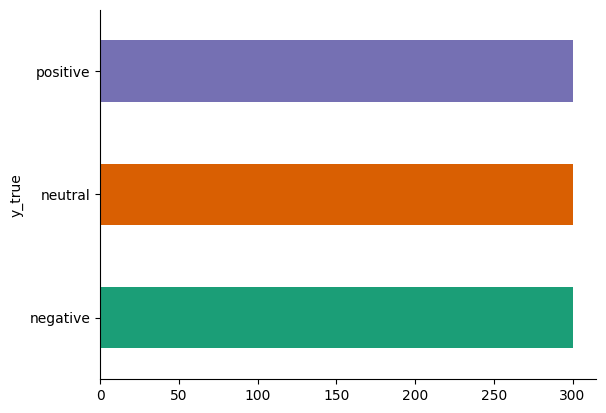

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
evaluation.groupby('y_true').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

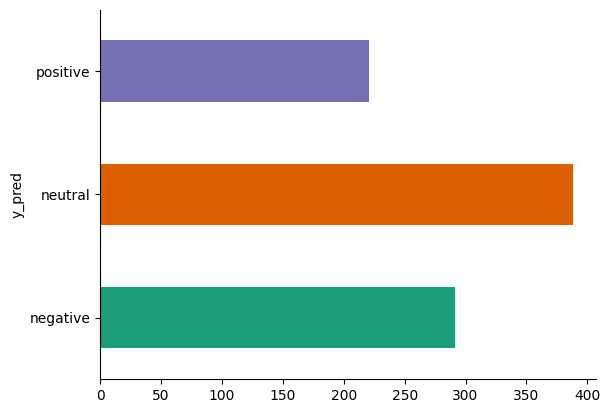

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
evaluation.groupby('y_pred').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

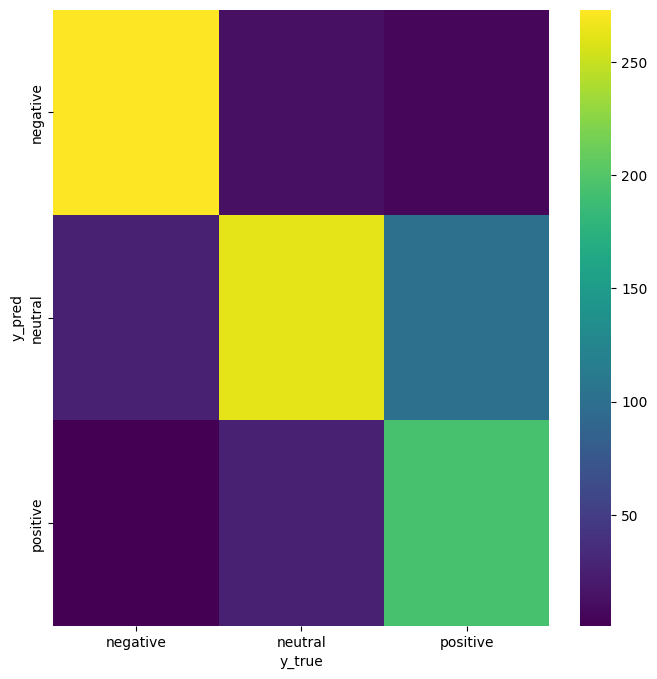

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['y_pred'].value_counts()
    for x_label, grp in evaluation.groupby('y_true')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('y_true')
_ = plt.ylabel('y_pred')

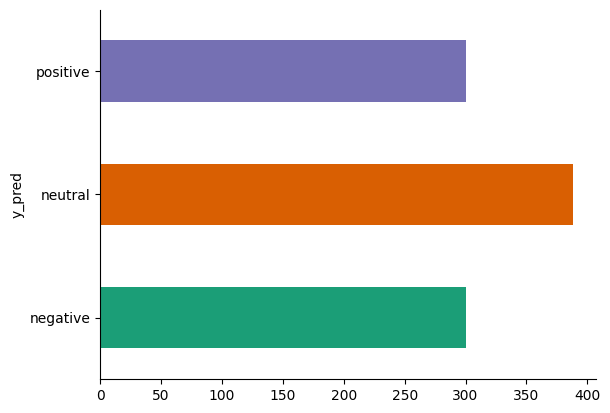

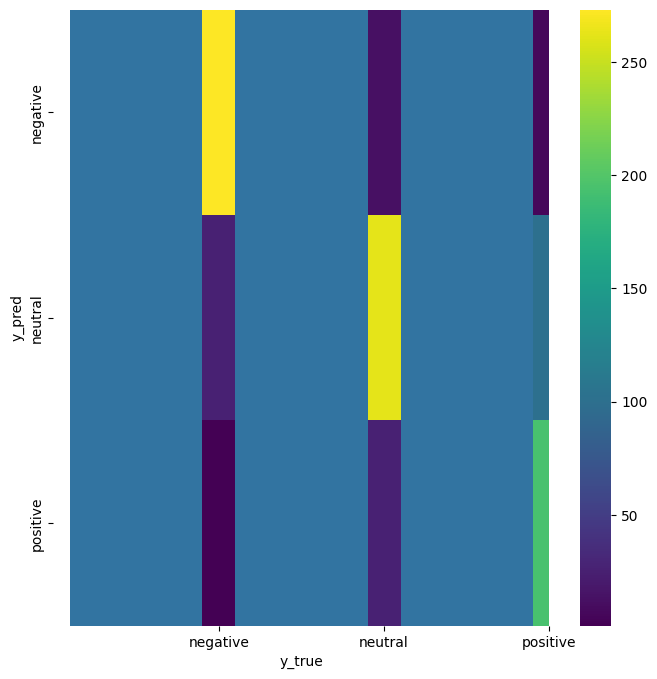

In [45]:
# after fine-tune
# Classification Report:
#               precision    recall  f1-score   support
#            0       0.94      0.91      0.92       300
#            1       0.68      0.87      0.76       300
#            2       0.88      0.65      0.74       300
#     accuracy                           0.81       900
#    macro avg       0.83      0.81      0.81       900
# weighted avg       0.83

evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)
evaluation.tail(10)
evaluation.groupby('y_true').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
evaluation.groupby('y_pred').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['y_pred'].value_counts()
    for x_label, grp in evaluation.groupby('y_true')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('y_true')
_ = plt.ylabel('y_pred')
sns.countplot(x='y_pred', data=evaluation)
plt.show()


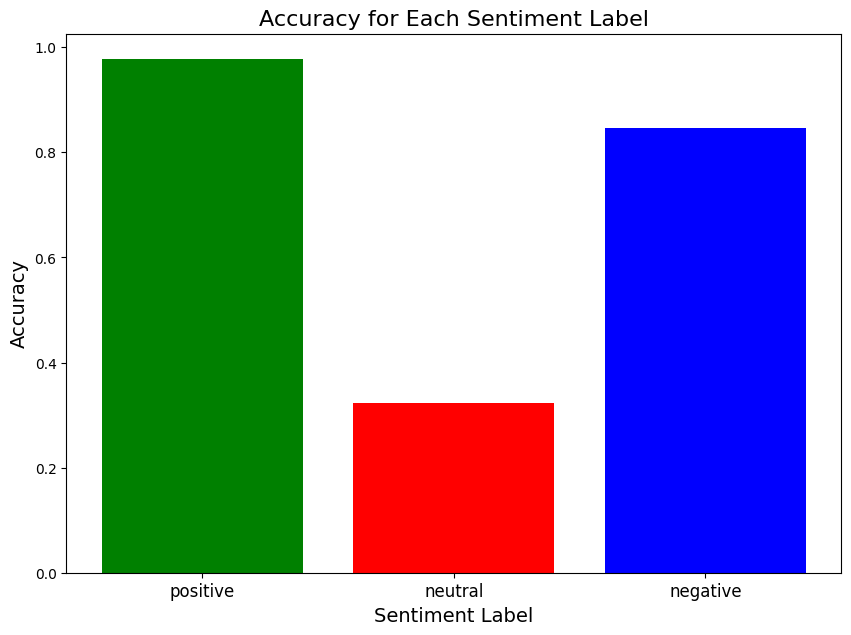

In [46]:
# before fine-tune (base model)
# Accuracy: 0.716
# Accuracy for label 0: 0.977
# Accuracy for label 1: 0.323
# Accuracy for label 2: 0.847
# Classification Report:
#               precision    recall  f1-score   support
#            0       0.75      0.98      0.85       300
#            1       0.81      0.32      0.46       300
#            2       0.65      0.85      0.74       300

labels = ['positive', 'neutral', 'negative']
x = [0, 1, 2]
y = [0.977, 0.323, 0.847]
bar_colors = ['green', 'red', 'blue']

plt.figure(figsize=(10, 7))
plt.bar(x, y, color=bar_colors)
plt.xlabel('Sentiment Label', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(x, labels, fontsize=12)
plt.title('Accuracy for Each Sentiment Label', fontsize=16)
plt.show()
